# Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
#dfrom fastdtw import fastdtw
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
# Stats
from scipy import stats
import scipy.stats
from scipy.stats import wilcoxon
from statsmodels.stats.anova import AnovaRM

from scipy.stats import mannwhitneyu
from statsmodels.stats.diagnostic import normal_ad
from scipy.stats import shapiro

# Análisis de datos EGG - Individual

In [16]:
# Datos que no varian:
workdir = '/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/'
canales =  [ 'TP9', 'AF7', 'AF8', 'TP10']
band_columns = [ 'Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']

dfs_labels = ['Silencio', 'Binaural Alfa', 'Ambiental']

Se realiza la lectura de los archivos de datos correspondientes a cada condición por sesión, datos de registro en silencio y datos de registro con música binaural o ambiental.

In [12]:

def read_filename(filename, filtrar=True, hora_limit = '00:08:00.000', date = '2023-12-23', ):
  # Lee el archivo CSV con los datos
  df = pd.read_csv(filename)
  # Convierte la columna 'TimeStamp' a formato datetime
  df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
  # Establecer la columna 'TimeStamp' desde la fecha '2023-12-23' y el minuto 0
  start_date = pd.Timestamp(date)
  df['TimeStamp'] = df['TimeStamp'] - df['TimeStamp'].min() + start_date

  del df['AUX_RIGHT']
  del df['RAW_TP9']
  del df['RAW_AF7']
  del df['RAW_AF8']
  del df['RAW_TP10']
  del df['Accelerometer_X']
  del df['Accelerometer_Y']
  del df['Accelerometer_Z']
  del df['Gyro_X']
  del df['Gyro_Y']
  del df['Gyro_Z']
  del df['HeadBandOn']
  del df['HSI_TP9']
  del df['HSI_AF7']
  del df['HSI_AF8']
  del df['HSI_TP10']
  del df['Battery']


  # Establece la fecha y hora límite
  fecha_limite = pd.Timestamp(f"2023-12-23 {hora_limit}")

  # Filtrar para eliminar el primer minuto de datos
  if filtrar:
    df_filtrado = df[df['TimeStamp'].dt.minute != 0]
  else:
    df_filtrado = df

  # Filtra el DataFrame para incluir solo datos hasta la fecha límite
  df_hasta_limite = df_filtrado[df_filtrado['TimeStamp'] <= fecha_limite]
  # Establecer la columna 'TimeStamp' como el índice
  df_hasta_limite.set_index('TimeStamp', inplace=True, drop=False)
  # Realiza un resampleo para que los datos esten por segundo.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
  # Resampleo a una frecuencia por segundo y rellenado hacia adelante (forward fill)
  df_amb_resample_sec = df_amb_resample.resample('S').asfreq()

  return df_amb_resample


**Estacionaria**.Prueba Dickey-Fuller. Ho: Serie No Estacionaria.
Si rechazamos Ho, la serie es estacionaria



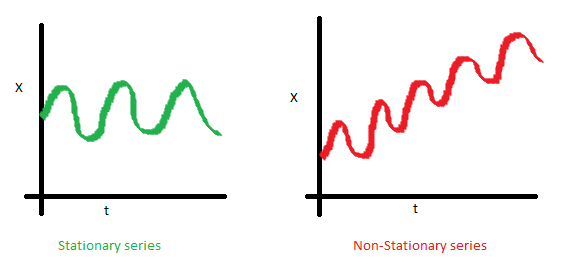

In [13]:
def hipotesis_estacionaria(valor_estadistico,valor_critico):
  if (valor_estadistico < valor_critico):
    print("Rechazamos - Serie Estacionaria")
  else:
    print("No Rechazamos - Serie NO Estacionaria")


## Funcion Generica

In [109]:
def read_data_user(id_usuario):
  ambiental =  workdir + id_usuario + '-ambiental.csv'
  silencio = workdir + id_usuario + '-silencio.csv'
  alfa =  workdir + id_usuario + '-binaural.csv'
  print(ambiental)


  df_silencio = read_filename(silencio)
  df_alfa = read_filename(alfa)
  df_amb = read_filename(ambiental)

  dfs = [df_silencio, df_alfa, df_amb]

  #for i, df in enumerate(dfs):
  #  print(f"ondas del registro {dfs_labels[i]}: {df.columns}")

  # Crear Array de las bandas a trabajar
  bands = []
  for wave in band_columns:
    for canal in canales:
      bands.append(f'{wave}_{canal}')

  for df in dfs:
    # Generar un valor promedio de la potencia con todos los canales por banda
    for wave in band_columns:
      df[wave] = 0
      for canal in canales:
        df[wave] += df[f'{wave}_{canal}']
        df[wave] = df[wave]/len(canales)

  # Validación de datos Nulos
  for i, df in enumerate(dfs):
    for banda in band_columns:
      #print(f"- Audio {dfs_labels[i]}. Onda {banda} ")
      df[banda] = df[banda].fillna(method='bfill')
      #print(f"   valores nulos {df[banda].isna().sum()}")

  for i, df in enumerate(dfs):
    for banda in band_columns:
      estadistico = sts.adfuller(df[banda])
      #print("----------------------------------------------------------------------")
      #print(f"Audio {dfs_labels[i]} - Banda {banda}")
      prueba = sts.adfuller(df[banda])
      valor_estadistico =prueba[0]
      valor_critico = prueba[4]['5%']
      #hipotesis_estacionaria(valor_estadistico,valor_critico )


  # Get QQ Plot Graphic
  # for banda in band_columns:
  #   for i, df in enumerate(dfs):
  #     scipy.stats.probplot(df[banda], plot=plt)
  #     plt.title(f"QQ plot {dfs_labels[i]} - {banda}", size=10)
  #     plt.show()



  wave_stats_values = []
  for i, df in enumerate(dfs):
    for wave in band_columns:
      wave_mean = df[wave].mean()
      wave_std = df[wave].std()
      wave_median = df[wave].median()
      wave_stats_values.append(wave_mean)
      wave_stats_values.append(wave_std)
      wave_stats_values.append(wave_median)
  return wave_stats_values



# Analisis de Datos - Grupos

In [110]:
# Lectura de datos
stats = [ 'mean', 'std', 'median']
wave_stats_labels = []
dfs_labels_g = ['sil', 'bin', 'amb']
for df in dfs_labels_g:
  for wave in band_columns:
    for stat in stats:
      wave_stats_labels.append(f'{df}_{wave}_{stat}')
wave_stats_labels.append('id_user')


values = []

# Iterar sobre el rango deseado
for i in range(1, 41):
    try:
      # Llamar a la función para obtener los valores correspondientes
      data = read_data_user(str(i))
      data.append(i)
      values.append(data)
    except:
      print(f"Error get file {i}")


df_stats = pd.DataFrame(values, columns=wave_stats_labels)

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/1-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/2-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/3-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/4-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/5-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/6-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/7-ambiental.csv
Error get file 7
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/8-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/9-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/10-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/11-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/12-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/13-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/14-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/15-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/16-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/17-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/18-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/19-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/20-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/21-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/22-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/23-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/24-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/25-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/26-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()


/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/27-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()


/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/28-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/29-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/30-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/31-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/32-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/33-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/34-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/35-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/36-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()


/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/37-ambiental.csv
/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/38-ambiental.csv

<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi


/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/39-ambiental.csv


<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

/content/drive/MyDrive/LAYDI VIVIANA/LAYDIHACKS/TFM - Muse/datos-tfm/EEG/40-ambiental.csv


In [111]:
df_stats.head(5)
df = df_stats

In [112]:
df.head(10)

,sil_Alpha_mean,sil_Alpha_std,sil_Alpha_median,sil_Beta_mean,sil_Beta_std,sil_Beta_median,bin_Alpha_mean,bin_Alpha_std,bin_Alpha_median,bin_Beta_mean,bin_Beta_std,bin_Beta_median,amb_Alpha_mean,amb_Alpha_std,amb_Alpha_median,amb_Beta_mean,amb_Beta_std,amb_Beta_median,id_user
0,0.209598,0.073195,0.214905,0.091031,0.026974,0.091581,0.221691,0.072186,0.219450,0.098298,0.025188,0.098792,0.210103,0.074356,0.207334,0.078695,0.033652,0.075744,1
1,0.664909,0.150068,0.660605,0.422279,0.140236,0.389900,0.658032,0.172368,0.674084,0.414316,0.154913,0.398721,0.657416,0.166743,0.653336,0.427609,0.160423,0.412296,2
2,0.493873,0.130857,0.482331,0.347733,0.085209,0.330879,0.603909,0.176484,0.563514,0.392986,0.140845,0.350202,0.560243,0.160270,0.521163,0.346238,0.123456,0.319050,3
3,0.203405,0.155737,0.136368,0.129514,0.125991,0.079619,0.481185,0.136175,0.465735,0.316276,0.089361,0.298947,0.476279,0.142223,0.435420,0.324258,0.111867,0.294014,4
4,0.612783,0.144816,0.605194,0.365326,0.123803,0.351273,0.560476,0.163934,0.522403,0.353934,0.145613,0.320890,0.536621,0.147913,0.554233,0.316986,0.110508,0.311925,5
5,0.113903,0.025075,0.120388,0.068759,0.017010,0.067171,0.397871,0.098993,0.446362,0.324977,0.071026,0.331961,0.495634,0.058519,0.507346,0.339054,0.042049,0.344935,6
6,0.234426,0.089936,0.204387,0.147703,0.025877,0.136849,0.275320,0.043607,0.276883,0.124944,0.025451,0.122788,0.018900,0.011148,0.017564,0.002206,0.005877,0.001539,8
7,0.170390,0.009754,0.170636,0.179413,0.005283,0.179241,0.177148,0.009646,0.178140,0.188262,0.005303,0.188752,0.339392,0.061087,0.351487,0.262492,0.029925,0.262272,9
8,0.414787,0.040836,0.414678,0.158213,0.034138,0.155900,0.423480,0.039416,0.423375,0.158693,0.026826,0.158444,0.414787,0.040836,0.414678,0.158213,0.034138,0.155900,10
9,0.183700,0.054758,0.180041,0.153098,0.029216,0.153030,0.280585,0.216584,0.196787,0.193769,0.153305,0.138874,0.164686,0.051551,0.169190,0.098351,0.033684,0.097383,11


### Pruebas NO parametricas EEG

In [131]:
def wilcoxon_eeg(wave1, wave2, string_ondas):
  # Realiza la prueba de Wilcoxon
  stat, p = wilcoxon(wave1, wave2, alternative='two-sided')
  # Nivel de Significación
  alpha = 0.10
  if p > alpha:
    print(f"- NO rechazamos Ho: No hay diferencias significativas {string_ondas}, stat: {stat} p: {p} ")
  else:
    print(f"- **Rechazamos Ho: Hay diferencias significativas {string_ondas}, stat: {stat}  p: {p} ")

#### **SILENCIO BINAURAL - ALPHA**

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


- NO rechazamos Ho: No hay diferencias significativas Alpha. Silencio - Binaural, stat: 354.0 p: 0.810880180872687 


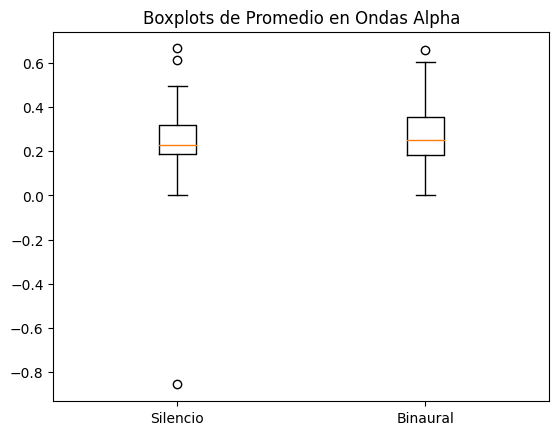

In [114]:
# Limpiar los datos eliminando espacios y convirtiéndolos a números
wave1 = df.sil_Alpha_mean
wave2 = df.bin_Alpha_mean

# Calculo de medias y Residuos
meanWave1 = np.mean(wave1)
meanWave2 = np.mean(wave2)

res1 = wave1 - meanWave1
res2 = wave2 - meanWave2
# Ejeccuón de Pruebas NO parametricas

string_ondas = "Alpha. Silencio - Binaural"
wilcoxon_eeg(wave1, wave2, string_ondas)

label_cases = ['Silencio', 'Binaural']
# Boxplots
plt.boxplot([wave1, wave2], labels=label_cases)
plt.title('Boxplots de Promedio en Ondas Alpha')
plt.show()

#### **SILENCIO BINAURAL - BETA**

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


- NO rechazamos Ho: No hay diferencias significativas Beta. Silencio - Binaural, stat: 307.0 p: 0.3570991869552058 


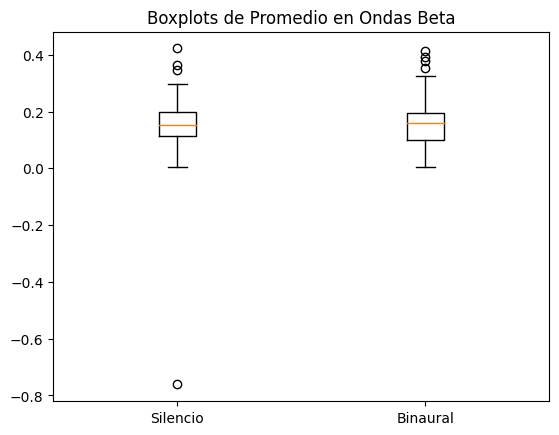

In [122]:
# Limpiar los datos eliminando espacios y convirtiéndolos a números
wave1 = df.sil_Beta_mean
wave2 = df.bin_Beta_mean

# Calculo de medias y Residuos
meanWave1 = np.mean(wave1)
meanWave2 = np.mean(wave2)

res1 = wave1 - meanWave1
res2 = wave2 - meanWave2
# Ejeccuón de Pruebas NO parametricas

string_ondas = "Beta. Silencio - Binaural"
wilcoxon_eeg(wave1, wave2, string_ondas)

label_cases = ['Silencio', 'Binaural']
# Boxplots
plt.boxplot([wave1, wave2], labels=label_cases)
plt.title('Boxplots de Promedio en Ondas Beta')
plt.show()

#### **SILENCIO AMBIENTAL - ALPHA**

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


- NO rechazamos Ho: No hay diferencias significativas Alpha. Silencio - Ambiental, stat: 370.0 p: 0.9942144037208491 


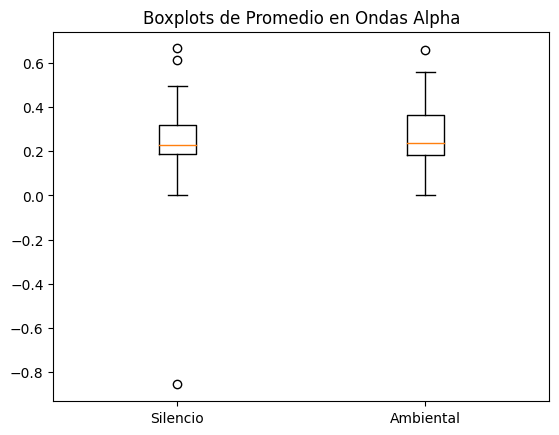

In [117]:
# Limpiar los datos eliminando espacios y convirtiéndolos a números
wave1 = df.sil_Alpha_mean
wave2 = df.amb_Alpha_mean

# Calculo de medias y Residuos
meanWave1 = np.mean(wave1)
meanWave2 = np.mean(wave2)

res1 = wave1 - meanWave1
res2 = wave2 - meanWave2
# Ejeccuón de Pruebas NO parametricas

string_ondas = "Alpha. Silencio - Ambiental"
wilcoxon_eeg(wave1, wave2, string_ondas)

label_cases = ['Silencio', 'Ambiental']
# Boxplots
plt.boxplot([wave1, wave2], labels=label_cases)
plt.title('Boxplots de Promedio en Ondas Alpha')
plt.show()

#### **SILENCIO AMBIENTAL - BETA**

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


- NO rechazamos Ho: No hay diferencias significativas Beta. Silencio - Ambiental, stat: 275.0 p: 0.16605689122071765 


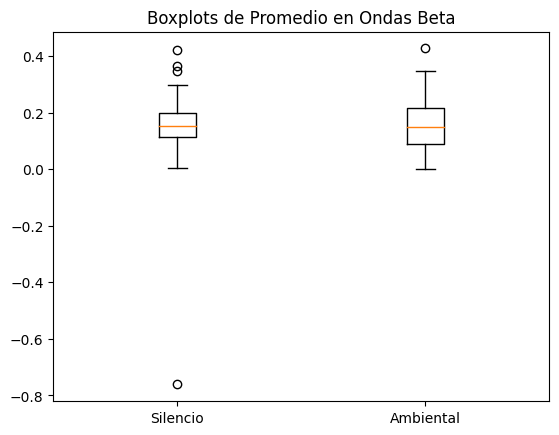

In [120]:
# Limpiar los datos eliminando espacios y convirtiéndolos a números
wave1 = df.sil_Beta_mean
wave2 = df.amb_Beta_mean

# Calculo de medias y Residuos
meanWave1 = np.mean(wave1)
meanWave2 = np.mean(wave2)

res1 = wave1 - meanWave1
res2 = wave2 - meanWave2
# Ejeccuón de Pruebas NO parametricas

string_ondas = "Beta. Silencio - Ambiental"
wilcoxon_eeg(wave1, wave2, string_ondas)

label_cases = ['Silencio', 'Ambiental']
# Boxplots
plt.boxplot([wave1, wave2], labels=label_cases)
plt.title('Boxplots de Promedio en Ondas Beta')
plt.show()

#### Experimental - Control

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


- **Rechazamos Ho: Hay diferencias significativas Beta. Silencio - Ambiental, stat: 192.0  p: 0.009634171566431633 


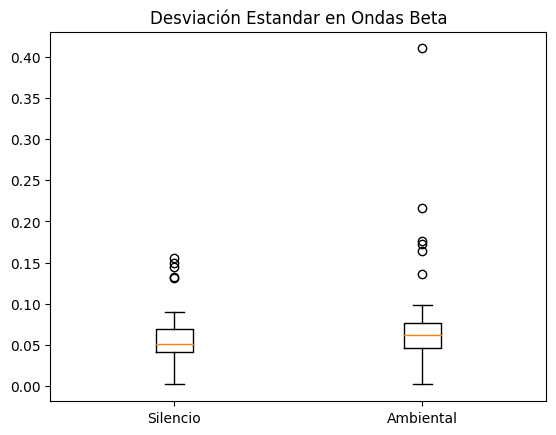

In [141]:
# Limpiar los datos eliminando espacios y convirtiéndolos a números
wave1 = df.sil_Alpha_std
wave2 = df.bin_Alpha_std

# Calculo de medias y Residuos
meanWave1 = np.mean(wave1)
meanWave2 = np.mean(wave2)

res1 = wave1 - meanWave1
res2 = wave2 - meanWave2
# Ejeccuón de Pruebas NO parametricas

string_ondas = "Beta. Silencio - Ambiental"
wilcoxon_eeg(wave1, wave2, string_ondas)

label_cases = ['Silencio', 'Ambiental']
# Boxplots
plt.boxplot([wave1, wave2], labels=label_cases)
plt.title('Desviación Estandar en Ondas Beta')
plt.show()

### Normalidad

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.00039500318981231593
Residuals are not normally distributed 

Using the Shapiro-Wilks test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0023067172151058912
Residuals are not normally distributed


<ipython-input-123-386e1c721faf>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res)


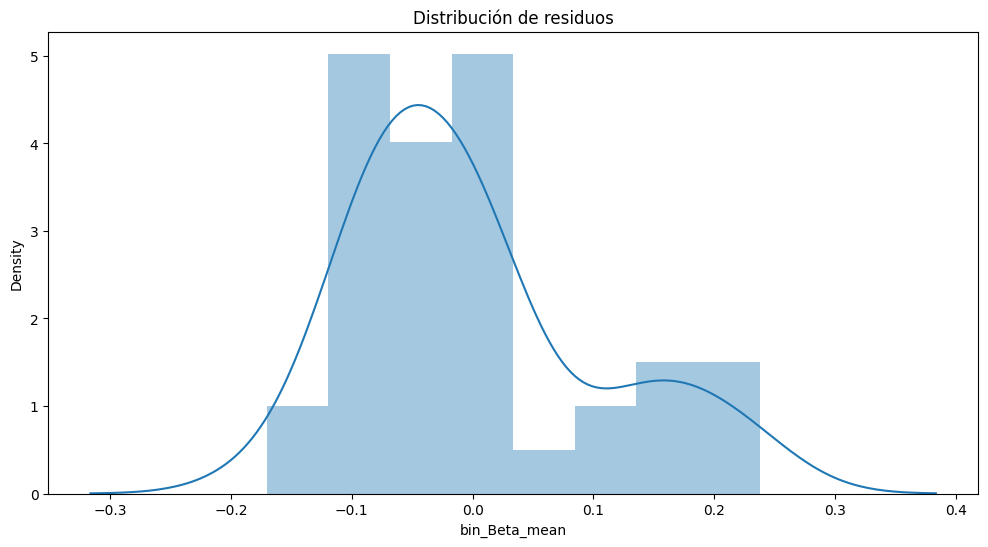


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables 



In [123]:
res = res2
# Performing the test on the residuals
p_value_thresh=0.05
print('Using the Anderson-Darling test for normal distribution')

p_value = normal_ad(res)[1]
print('p-value from the test - below 0.05 generally means non-normal:', p_value)

# Reporting the normality of the residuals
if p_value < p_value_thresh:
  print('Residuals are not normally distributed', '\n')
else:
  print('Residuals are normally distributed', '\n')

print('Using the Shapiro-Wilks test for normal distribution')
shapiro_test = shapiro(res)
shapiro_test_stat=shapiro_test[0]
shapiro_test_pvalue=shapiro_test[1]
print('p-value from the test - below 0.05 generally means non-normal:', shapiro_test_pvalue)

# Reporting the normality of the residuals
if shapiro_test_pvalue < p_value_thresh:
  print('Residuals are not normally distributed')
else:
  print('Residuals are normally distributed')

# Plotting the residuals distribution
plt.subplots(figsize=(12, 6))
plt.title('Distribución de residuos')
sns.distplot(res)
plt.show()

print()
if p_value > p_value_thresh:
  print('Assumption satisfied', '\n')
else:
  print('Assumption not satisfied')
  print()
  print('Confidence intervals will likely be affected')
  print('Try performing nonlinear transformations on variables', '\n')


# Visualización de datos EGG

In [105]:

#DATOS DEL USUARIO
id_usuario='25'
dfs_labels = ['Silencio', 'Binaural Alfa', 'Ambiental']
canales =  [ 'TP9', 'AF7', 'AF8', 'TP10']
band_columns = [ 'Alpha', 'Beta']


ambiental =  workdir + id_usuario + '-ambiental.csv'
silencio = workdir + id_usuario + '-silencio.csv'
alfa =  workdir + id_usuario + '-binaural.csv'

df_silencio = read_filename(silencio)
df_alfa = read_filename(alfa)
df_amb = read_filename(ambiental)

dfs = [df_silencio, df_alfa, df_amb]

# Crear Array de las bandas a trabajar
bands = []
for wave in band_columns:
  for canal in canales:
    bands.append(f'{wave}_{canal}')

for df in dfs:
  # Generar un valor promedio de la potencia con todos los canales por banda
  for wave in band_columns:
    df[wave] = 0
    for canal in canales:
      df[wave] += df[f'{wave}_{canal}']
      df[wave] = df[wave]/len(canales)

# Validación de datos Nulos
for i, df in enumerate(dfs):
  for banda in band_columns:
    #print(f"- Audio {dfs_labels[i]}. Onda {banda} ")
    df[banda] = df[banda].fillna(method='bfill')
    #print(f"   valores nulos {df[banda].isna().sum()}")

for i, df in enumerate(dfs):
  for banda in band_columns:
    estadistico = sts.adfuller(df[banda])
    #print("----------------------------------------------------------------------")
    #print(f"Audio {dfs_labels[i]} - Banda {banda}")
    prueba = sts.adfuller(df[banda])
    valor_estadistico =prueba[0]
    valor_critico = prueba[4]['5%']
    #hipotesis_estacionaria(valor_estadistico,valor_critico )



<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limite.resample('1S', on='TimeStamp').mean()
<ipython-input-12-142ed12f2dcd>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_amb_resample = df_hasta_limi

### Graficas de Datasets por Ondas

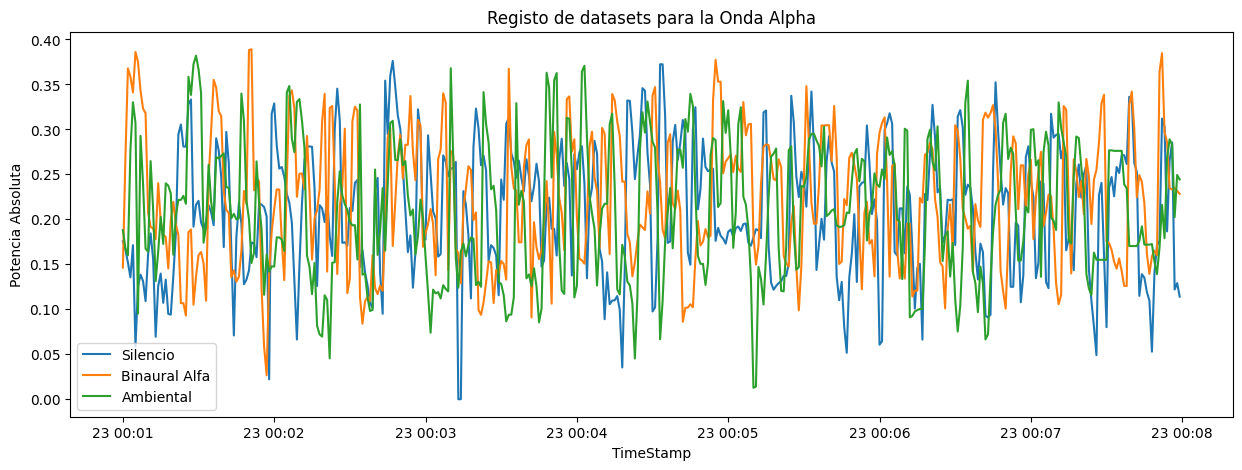

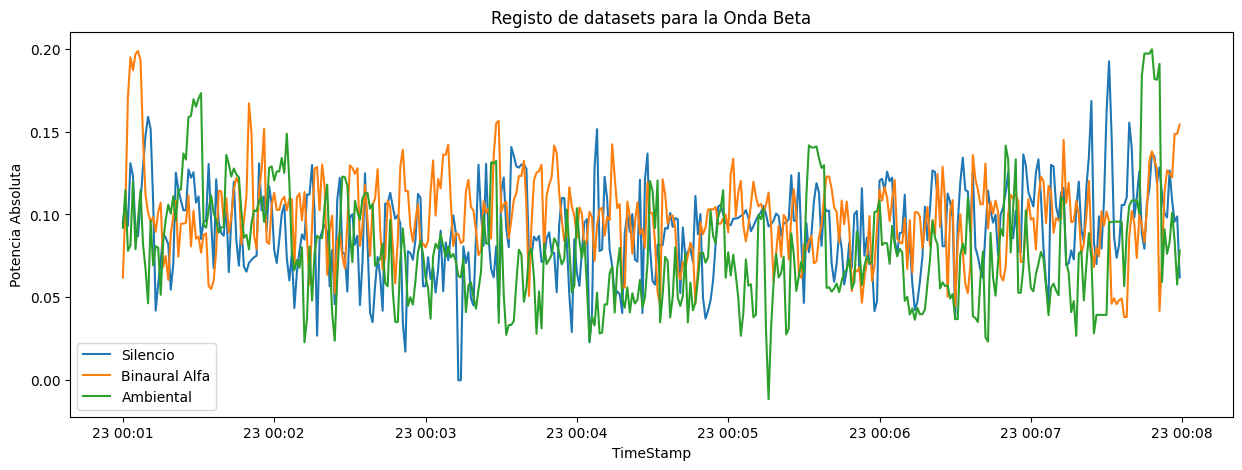

In [106]:


# Graficar las columnas 'alpha' de cada DataFrame
for wave in band_columns:
  plt.figure(figsize=(15, 5))
  for i, df in enumerate(dfs):
    plt.plot(df.index, df[wave], label=dfs_labels[i])

  # Configuración de la gráfica
  plt.title('Registo de datasets para la Onda ' + wave)
  plt.xlabel('TimeStamp')
  plt.ylabel('Potencia Absoluta')
  plt.legend()

  # Mostrar la gráfica
  plt.show()

### Grafica de Ondas por Dataset

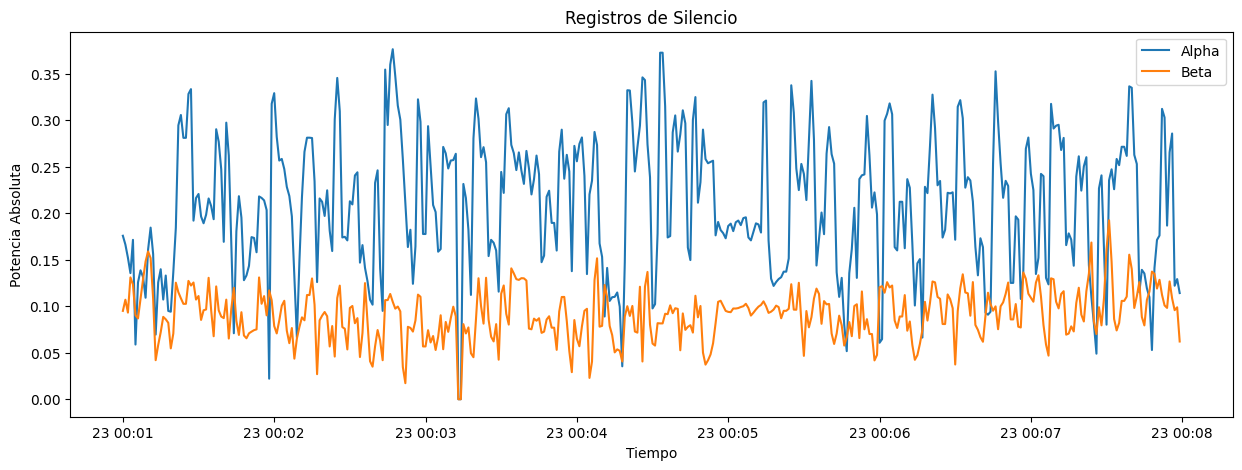

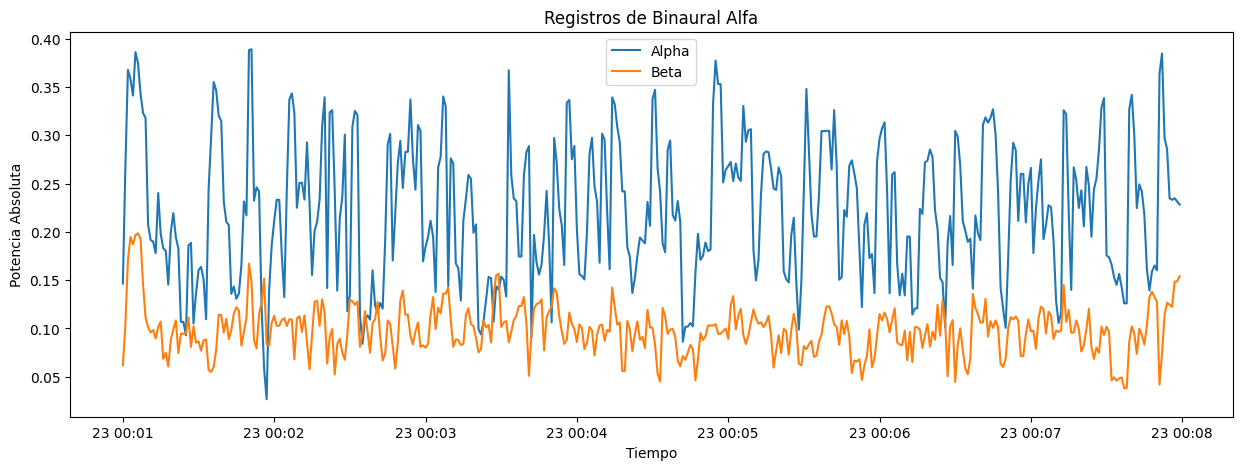

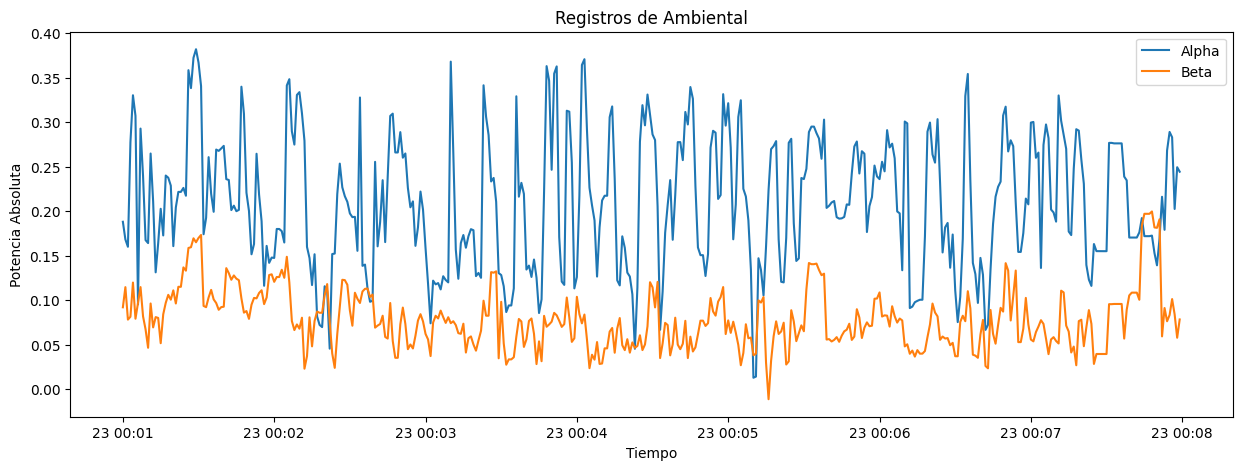

In [107]:
for i, df in enumerate(dfs):
  plt.figure(figsize=(15, 5))
  for wave in band_columns:
    sns.lineplot(x=df.index, y=df[wave], data=df, label=wave)

  plt.title('Registros de ' + dfs_labels[i])
  plt.xlabel('Tiempo')
  plt.ylabel('Potencia Absoluta')
  plt.legend()
  plt.show()